# Explaining GNN Model Predictions using Captum

ZeMaML dataset from [PTB-Berlin](https://). This dataset consists of 11 different sensors where the task is to predict the link using correlation as an edge attributes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q captum

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import numpy as  np
import itertools
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft, fftfreq
import pandas as pd
import random

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 41.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.9 MB/s eta 0:00:00


## Loading the dataset

load the dataset (10% of the data as the test split)

In [3]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data
import os

# proxy = 'http://webproxy:8080'

# os.environ['http_proxy'] = proxy
# os.environ['HTTP_PROXY'] = proxy
# os.environ['https_proxy'] = proxy
# os.environ['HTTPS_PROXY'] = proxy

In [4]:
achse_mat = scipy.io.loadmat('/content/drive/MyDrive/Achse11_Szenario.mat')

trainData = achse_mat['trainData']
train_data_reshaped = []
for counter, val in enumerate(trainData):
    train_data_reshaped += [val[0]]
train_data_reshaped = np.array(train_data_reshaped)
train_data_reshaped = np.swapaxes(train_data_reshaped, 0, 1)

train_target_reshaped = achse_mat['trainTarget'].reshape(-1)

sensor_names = ['Mic', 'Acc_PB', 'Acc_BB', 'Acc_PR', 'Ax_F', 'Pres', 'Vel', 'Act_Curr', 'Mot_Curr_1', 'Mot_Curr_2', 'Mot_Curr_3']

/usr/local/lib/python3.10/dist-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
ranges = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Perform label encoding
def label_mapping(x):
    return labels[x - 1]

# Perform label encoding
encoded_target = np.digitize(train_target_reshaped, ranges, right=True)
train_target_reshaped = np.vectorize(label_mapping)(encoded_target)

print((train_target_reshaped).shape)

(4766,)


In [6]:
print(train_target_reshaped.dtype)

int64


In [7]:
train_target_reshaped

array([ 1,  1,  1, ..., 10, 10, 10])

In [8]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation.
    Shifted data filled with NaNs

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

## Convert time-series data to torch geometric graph data. 1. Fully connected graph with 55 edges. Each edge has the correlation between the sensors as an attribute.

## 2. Reduce number of edges by distarding those with a "below average" correlation

In [9]:
dataset = []
combs = list(itertools.combinations(range(11), 2))
edge_index_perm = torch.tensor(np.array(combs).T)
triu_ind = np.triu_indices(11, k = 1)
N = 2000
Tsig = 1 / 2000.0
seconds = 5
fps = 50
for k, sample in enumerate(train_data_reshaped):
    corr_mat = np.corrcoef(sample)
    corr_vec = np.reshape(corr_mat[triu_ind], (55,-1))
    corr_edge_inds = np.argwhere(np.abs(corr_vec) > np.abs(corr_vec).mean())
    edge_inds = edge_index_perm[:, corr_edge_inds[:,0]]
    offset = []

    edge_attr = corr_vec[corr_edge_inds[:,0]]
    scaler = StandardScaler()
    array = scaler.fit_transform(sample.T).T
    array_fft = np.abs(fft(array)[:N//2])
    dataset += [Data(edge_index=edge_inds.long(), x=torch.tensor(array).float(), edge_attr=torch.tensor(edge_attr).float(), y=torch.tensor([train_target_reshaped[k]]).float())]
random.seed(42)
random.shuffle(dataset)
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]

In [10]:
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [11]:
y_list = [data.y for data in train_dataset]
print(y_list)

[tensor([4.]), tensor([6.]), tensor([2.]), tensor([2.]), tensor([5.]), tensor([9.]), tensor([8.]), tensor([1.]), tensor([2.]), tensor([9.]), tensor([7.]), tensor([3.]), tensor([5.]), tensor([2.]), tensor([2.]), tensor([2.]), tensor([9.]), tensor([4.]), tensor([1.]), tensor([5.]), tensor([10.]), tensor([7.]), tensor([3.]), tensor([2.]), tensor([10.]), tensor([7.]), tensor([7.]), tensor([3.]), tensor([1.]), tensor([10.]), tensor([10.]), tensor([10.]), tensor([9.]), tensor([1.]), tensor([4.]), tensor([6.]), tensor([9.]), tensor([1.]), tensor([4.]), tensor([5.]), tensor([6.]), tensor([6.]), tensor([8.]), tensor([2.]), tensor([7.]), tensor([7.]), tensor([5.]), tensor([2.]), tensor([2.]), tensor([10.]), tensor([10.]), tensor([10.]), tensor([7.]), tensor([3.]), tensor([4.]), tensor([6.]), tensor([10.]), tensor([2.]), tensor([8.]), tensor([6.]), tensor([9.]), tensor([5.]), tensor([6.]), tensor([9.]), tensor([1.]), tensor([7.]), tensor([3.]), tensor([7.]), tensor([2.]), tensor([10.]), tensor([8

In [12]:
#print(array_fft)

## Visualizing the data


In [13]:
import networkx as nx
import numpy as np

from torch_geometric.utils import to_networkx

color_list = ['red', 'yellow']
rng = np.random.default_rng()

def draw_molecule(g, edge_mask=None, draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    d = dict(g.degree)
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
    widths = [7*np.abs(g[u][v]['edge_attr'])**.5 for u, v in g.edges()]
    nx.draw(g, pos=pos, labels=node_labels, width=.5,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color=rng.choice([t for t in color_list], size=g.number_of_nodes()), node_size=[v * 500 for v in d.values()]
)

    nx.draw_networkx_edges(g, pos, width=widths, alpha=0.5)

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red', node_size=[v * 100 for v in d.values()])
    plt.show()


def to_molecule(data):
    g = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])
    for u, data in g.nodes(data=True):
        data['name'] = sensor_names[u]
    return g

## Sample visualization

We sample a single molecule from train_dataset and visualize it

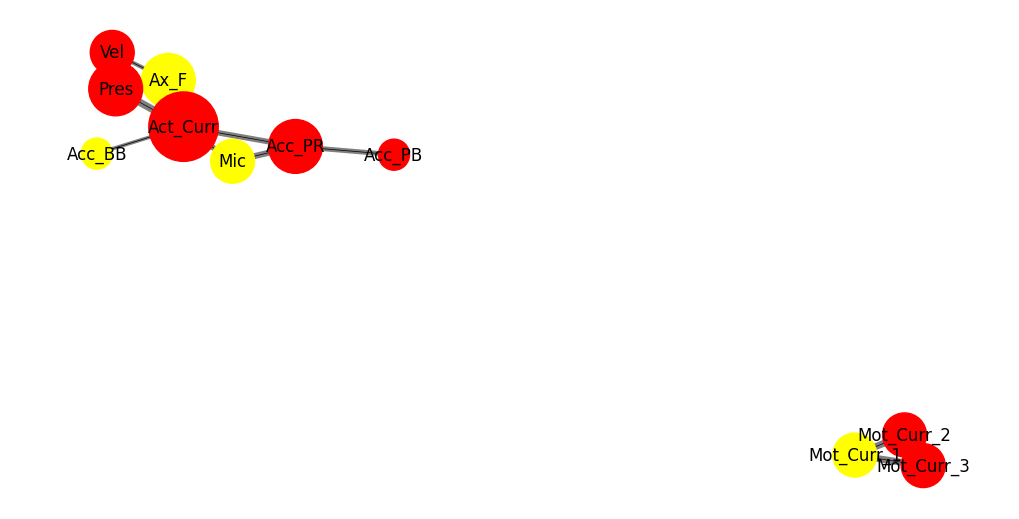

In [57]:
# data_1 = random.choice([t for t in train_dataset])
data_1 = dataset[10]
mol = to_molecule(data_1)
plt.figure(figsize=(10, 5))
draw_molecule(mol)

In [15]:
for u, v in mol.edges():
    print(10*np.abs(mol[u][v]['edge_attr'])**.5)

4.651483291243734
5.473415836658344
3.9141550186400274
3.962863747179868
4.323313093584126
4.038036120106285
9.675293584800006
4.060533304269782
8.46702284989856
6.703887958277158
8.203207469707285
7.072372136529439
7.1018245971792595
7.037390888310076


***GCN Model***

In [16]:
# import torch
# from torch.nn import Linear
# import torch.nn.functional as F

# from torch_geometric.nn import GraphConv, global_add_pool, global_mean_pool
# num_features = train_data_reshaped.shape[2]
# #num_features = array_fft.shape
# num_classes = len(ranges)

# class Net(torch.nn.Module):
#     def __init__(self, dim):
#         super(Net, self).__init__()
#         #num_features = dataset.num_features
#         self.dim = dim

#         self.conv1 = GraphConv(num_features, dim)
#         self.conv2 = GraphConv(dim, dim)
#         self.conv3 = GraphConv(dim, dim)
# #         self.conv4 = GraphConv(dim, dim)
# #         self.conv5 = GraphConv(dim, dim)

#         self.lin1 = Linear(dim, dim)
#         #self.lin2 = Linear(dim, dataset.num_classes)
#         self.lin2 = Linear(dim, num_classes)

#     def forward(self, x, edge_index, batch, edge_weight=None):
#         x = self.conv1(x, edge_index, edge_weight).relu()
#         x = self.conv2(x, edge_index, edge_weight).relu()
#         x = self.conv3(x, edge_index, edge_weight).relu()
# #         x = self.conv4(x, edge_index, edge_weight).relu()
# #         x = self.conv5(x, edge_index, edge_weight).relu()
#         x = global_mean_pool(x, batch)
#         x = self.lin1(x).relu()
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = self.lin2(x)
#         return F.log_softmax(x, dim=-1)


In [17]:
# def train(epoch):
#     model.train()

#     if epoch == 51:
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = 0.5 * param_group['lr']

#     loss_all = 0
#     for data in train_loader:
#         data = data.to(device)
#         optimizer.zero_grad()
#         output = model(data.x, data.edge_index, data.batch)

#         # target = data.y.reshape(-1).long()
#         # target = target.view(-1, 1).repeat(1, data.x.size(1)).view(-1)
#         # loss = F.nll_loss(output, target)

#         loss = F.nll_loss(output, data.y.long())
#         loss.backward()
#         loss_all += loss.item() * data.num_graphs
#         optimizer.step()
#     return loss_all / len(train_dataset)


# def test(loader):
#     model.eval()

#     correct = 0
#     for data in loader:
#         data = data.to(device)
#         output = model(data.x, data.edge_index, data.batch)
#         pred = output.max(dim=1)[1]
#         #print(pred)
#         correct += pred.eq(data.y).sum().item()
#         #print(correct)

#     return correct / len(loader.dataset)

In [18]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net(dim=32).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# loss_values = []
# train_acc_values = []
# test_acc_values = []
# epochs= []
# num_epochs = 20
# patience = 3
# best_val_loss = float('inf')
# best_model = None
# no_improvement = 0

# for epoch in range(1, num_epochs + 1):
#     loss = train(epoch)
#     train_acc = test(train_loader)
#     test_acc = test(test_loader)

#     loss_values.append(loss)
#     train_acc_values.append(train_acc)
#     test_acc_values.append(test_acc)
#     epochs.append(epoch)

#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
#           f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

#     # Check if validation loss improved
#     if len(loss_values) > 1 and loss_values[-1] >= loss_values[-2]:
#         no_improvement += 1
#     else:
#         no_improvement = 0

#     # Check if early stopping condition is met
#     if no_improvement >= patience:
#         print(f"Early stopping. No improvement for {no_improvement} epochs.")
#         break


Epoch: 001, Loss: 2.0914, Train Acc: 0.6473, Test Acc: 0.6303
Epoch: 002, Loss: 1.4017, Train Acc: 0.7739, Test Acc: 0.7101
Epoch: 003, Loss: 1.0541, Train Acc: 0.8005, Test Acc: 0.7290
Epoch: 004, Loss: 0.8781, Train Acc: 0.8196, Test Acc: 0.7710
Epoch: 005, Loss: 0.7572, Train Acc: 0.8357, Test Acc: 0.7668
Epoch: 006, Loss: 0.6703, Train Acc: 0.8592, Test Acc: 0.8004
Epoch: 007, Loss: 0.6195, Train Acc: 0.8788, Test Acc: 0.7899
Epoch: 008, Loss: 0.5705, Train Acc: 0.8904, Test Acc: 0.7836
Epoch: 009, Loss: 0.5170, Train Acc: 0.9065, Test Acc: 0.8361
Epoch: 010, Loss: 0.4819, Train Acc: 0.9147, Test Acc: 0.8319
Epoch: 011, Loss: 0.4790, Train Acc: 0.9205, Test Acc: 0.8235
Epoch: 012, Loss: 0.4223, Train Acc: 0.9233, Test Acc: 0.8340
Epoch: 013, Loss: 0.3881, Train Acc: 0.9389, Test Acc: 0.8445
Epoch: 014, Loss: 0.3667, Train Acc: 0.9529, Test Acc: 0.8592
Epoch: 015, Loss: 0.3452, Train Acc: 0.9308, Test Acc: 0.8382
Epoch: 016, Loss: 0.3327, Train Acc: 0.9597, Test Acc: 0.8571
Epoch: 0

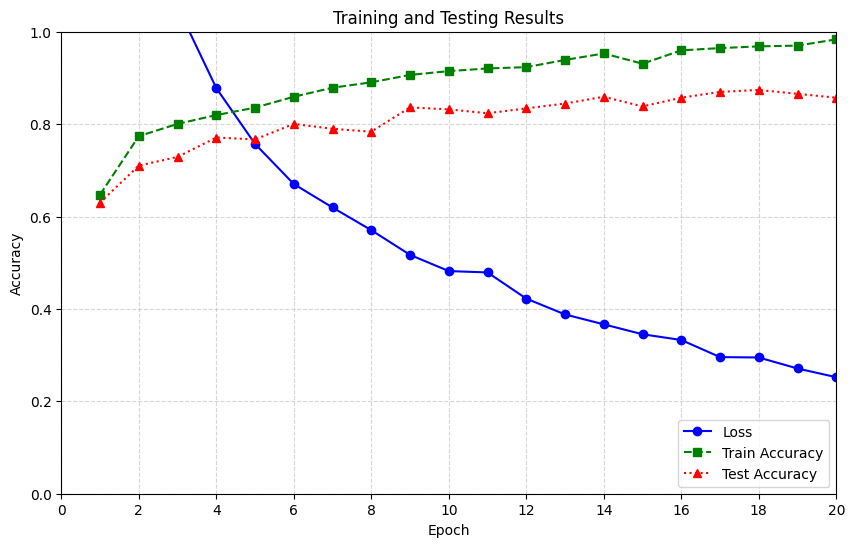

In [19]:
# plt.figure(figsize=(10, 6))

# # Plot lines with different styles and colors
# plt.plot(epochs , loss_values, color='blue', linestyle='-', marker='o', label='Loss')
# plt.plot(epochs , train_acc_values, color='green', linestyle='--', marker='s', label='Train Accuracy')
# plt.plot(epochs , test_acc_values, color='red', linestyle=':', marker='^', label='Test Accuracy')

# # Set title and labels
# plt.title('Training and Testing Results')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

# # Add legend and position it
# plt.legend(loc='lower right')

# # Add gridlines
# plt.grid(True, linestyle='--', alpha=0.5)

# # Adjust axis limits and ticks
# plt.xlim(1, 20)
# plt.xticks(range(0, 22, 2))
# plt.ylim(0, 1.0)
# plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# plt.show()

***GAT Model***

In [34]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GraphConv, global_add_pool, global_mean_pool, GATConv
num_features = train_data_reshaped.shape[2]
num_classes = len(ranges)

class Gat(torch.nn.Module):
    def __init__(self, hidden_dim ,num_heads):
        super(Gat, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim, heads=num_heads)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
        self.conv3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
       # self.conv4 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)


        self.lin1 = Linear(hidden_dim * num_heads, hidden_dim)
        self.lin2 = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.conv3(x, edge_index, edge_weight).relu()
#         x = self.conv4(x, edge_index, edge_weight).relu()
#         x = self.conv5(x, edge_index, edge_weight).relu()
        x = global_mean_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Gat(hidden_dim=32, num_heads=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_values = []
train_acc_values = []
test_acc_values = []
epochs= []
num_epochs = 100
patience = 2
best_val_loss = float('inf')
best_model = None
no_improvement = 0

for epoch in range(1, num_epochs + 1):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    loss_values.append(loss)
    train_acc_values.append(train_acc)
    test_acc_values.append(test_acc)
    epochs.append(epoch)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Check if validation loss improved
    if len(loss_values) > 1 and loss_values[-1] >= loss_values[-2]:
        no_improvement += 1
    else:
        no_improvement = 0

    # Check if early stopping condition is met
    if no_improvement >= patience:
        print(f"Early stopping. No improvement for {no_improvement} epochs.")
        break


Epoch: 001, Loss: 1.7903, Train Acc: 0.7524, Test Acc: 0.7185
Epoch: 002, Loss: 0.9667, Train Acc: 0.8172, Test Acc: 0.7647
Epoch: 003, Loss: 0.7244, Train Acc: 0.8471, Test Acc: 0.7773
Epoch: 004, Loss: 0.6132, Train Acc: 0.8755, Test Acc: 0.8067
Epoch: 005, Loss: 0.5236, Train Acc: 0.8958, Test Acc: 0.8214
Epoch: 006, Loss: 0.4572, Train Acc: 0.9117, Test Acc: 0.8361
Epoch: 007, Loss: 0.4126, Train Acc: 0.9270, Test Acc: 0.8424
Epoch: 008, Loss: 0.3495, Train Acc: 0.9401, Test Acc: 0.8508
Epoch: 009, Loss: 0.3143, Train Acc: 0.9552, Test Acc: 0.8613
Epoch: 010, Loss: 0.2993, Train Acc: 0.9473, Test Acc: 0.8739
Epoch: 011, Loss: 0.2851, Train Acc: 0.9646, Test Acc: 0.8529
Epoch: 012, Loss: 0.2332, Train Acc: 0.9716, Test Acc: 0.8782
Epoch: 013, Loss: 0.2165, Train Acc: 0.9730, Test Acc: 0.8550
Epoch: 014, Loss: 0.1721, Train Acc: 0.9802, Test Acc: 0.8718
Epoch: 015, Loss: 0.1795, Train Acc: 0.9848, Test Acc: 0.8655
Epoch: 016, Loss: 0.1853, Train Acc: 0.9869, Test Acc: 0.8739
Early st

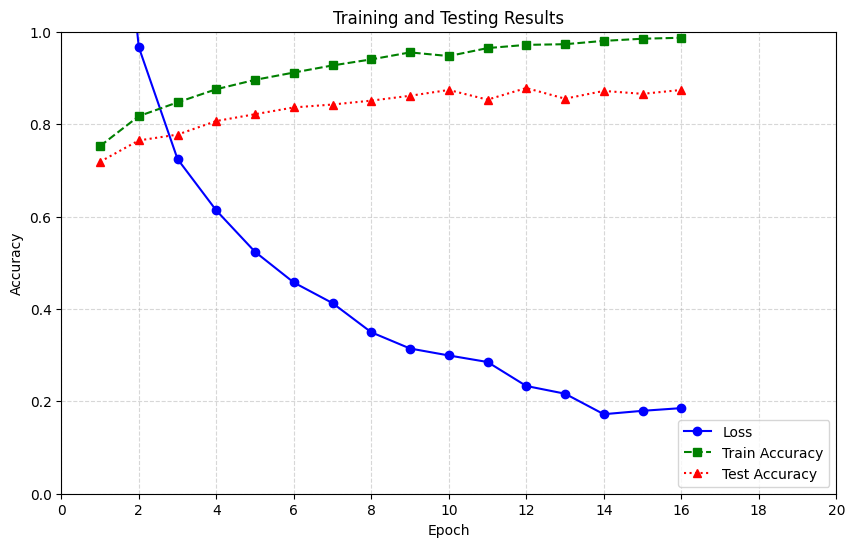

In [36]:
plt.figure(figsize=(10, 6))

# Plot lines with different styles and colors
plt.plot(epochs , loss_values, color='blue', linestyle='-', marker='o', label='Loss')
plt.plot(epochs , train_acc_values, color='green', linestyle='--', marker='s', label='Train Accuracy')
plt.plot(epochs , test_acc_values, color='red', linestyle=':', marker='^', label='Test Accuracy')

# Set title and labels
plt.title('Training and Testing Results')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add legend and position it
plt.legend(loc='lower right')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust axis limits and ticks
plt.xlim(1, 20)
plt.xticks(range(0, 22, 2))
plt.ylim(0, 1.0)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [20]:
# from captum.attr import Saliency, IntegratedGradients

# def model_forward(edge_mask, data):
#     batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
#     out = model(data.x, data.edge_index, batch, edge_mask)
#     return out


# def explain(method, data, target=0):
#     input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
#     if method == 'ig':
#         ig = IntegratedGradients(model_forward)
#         mask = ig.attribute(input_mask, target=target,
#                             additional_forward_args=(data,),
#                             internal_batch_size=data.edge_index.shape[1])
#     elif method == 'saliency':
#         saliency = Saliency(model_forward)
#         mask = saliency.attribute(input_mask, target=target,
#                                   additional_forward_args=(data,))
#     else:
#         raise Exception('Unknown explanation method')

#     edge_mask = np.abs(mask.cpu().detach().numpy())
#     if edge_mask.max() > 0:  # avoid division by zero
#         edge_mask = edge_mask / edge_mask.max()
#     return edge_mask

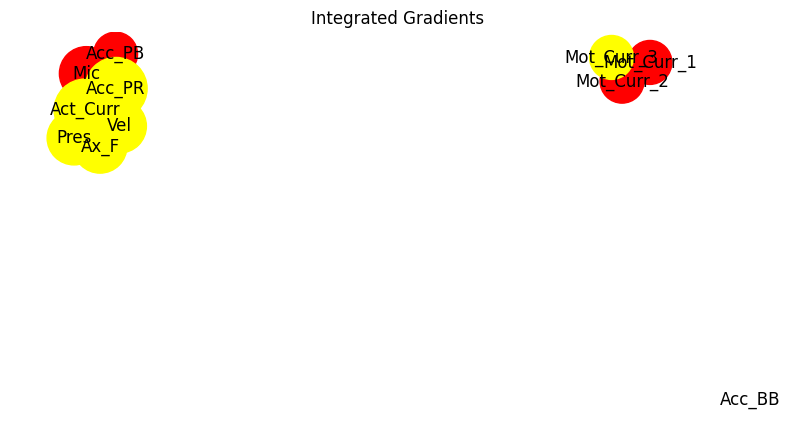

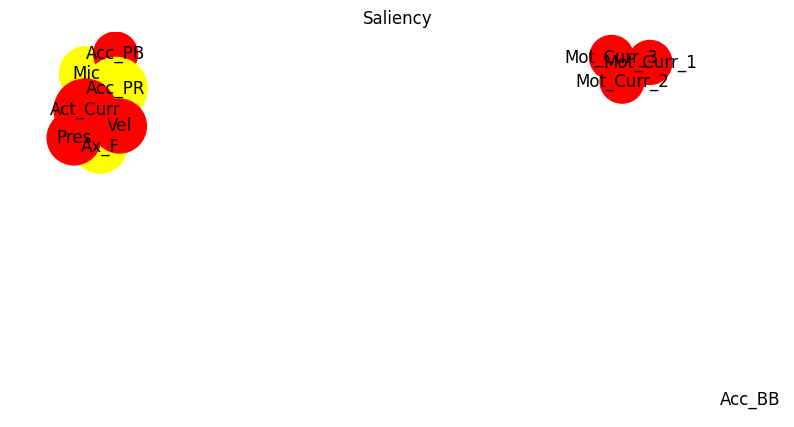

In [21]:
# import random
# from collections import defaultdict

# def aggregate_edge_directions(edge_mask, data):
#     edge_mask_dict = defaultdict(float)
#     for val, u, v in list(zip(edge_mask, *data.edge_index)):
#         u, v = u.item(), v.item()
#         if u > v:
#             u, v = v, u
#         edge_mask_dict[(u, v)] += val
#     return edge_mask_dict


# data = random.choice([t for t in test_dataset])
# mol = to_molecule(data)

# for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
#     edge_mask = explain(method, data, target=8)
#     edge_mask_dict = aggregate_edge_directions(edge_mask, data)
#     plt.figure(figsize=(10, 5))
#     plt.title(title)
#     draw_molecule(mol, edge_mask_dict)

In [22]:
from torch_geometric.explain import Explainer
from torch_geometric.explain.config import ModelConfig
from torch_geometric.explain.config import ExplainerConfig
from torch_geometric.explain.algorithm import GNNExplainer
from torch_geometric.explain.algorithm import PGExplainer
from torch_geometric.explain.algorithm import AttentionExplainer
from torch_geometric.explain.algorithm import CaptumExplainer
from torch_geometric.explain.metric import groundtruth_metrics
from torch_geometric.explain.metric import fidelity

In [23]:
# model_config = ModelConfig(mode="multiclass_classification", task_level="edge",return_type="log_probs")

# gnn_explainer = Explainer(
#     model=model,
#     explanation_type='model',
#     algorithm=GNNExplainer(epochs=200),
#     node_mask_type='attributes',
#     edge_mask_type='object',
#     model_config=model_config,
#     )


In [24]:
# explanation1 = gnn_explainer(data.x, data.edge_index, batch = data.batch)
# explanation1.validate()

In [25]:
# path = 'feature_importance.png'
# explanation1.visualize_feature_importance(path, top_k=10)
# print(f"Feature importance plot has been saved to '{path}'")

# path = 'subgraph.pdf'
# explanation1.visualize_graph(path)
# print(f"Subgraph plot has been saved to '{path}'")

In [26]:
# explainer = Explainer(
#     model=model,
#     algorithm=GNNExplainer(epochs=200),
#     explanation_type='model',
#     node_mask_type='object',
#     edge_mask_type='object',
#     model_config=dict(
#         mode='multiclass_classification',
#         task_level='node',
#         return_type='log_probs',  # Model returns log probabilities.
#     ),
# )

# # Generate explanation for the node at index `10`:
# explanation = explainer(dataset[10].x, dataset[10].edge_index ,batch = data.batch)
# print(explanation.edge_mask)
# print(explanation.node_mask)

In [27]:
# explanation.validate()

In [28]:
# loader = DataLoader(dataset, batch_size=1, shuffle=True)

# explainer = Explainer(
#     model=model,
#     algorithm=PGExplainer(epochs=30, lr=0.003),
#     explanation_type='phenomenon',
#     edge_mask_type='object',
#     model_config=dict(
#         mode='regression',
#         task_level='graph',
#         return_type='raw',
#     ),
#     # Include only the top 10 most important edges:
#     threshold_config=dict(threshold_type='topk', value=10),
# )

# # PGExplainer needs to be trained separately since it is a parametric
# # explainer i.e it uses a neural network to generate explanations:
# for epoch in range(30):
#     for batch in loader:
#         loss = explainer.algorithm.train(
#             epoch, model, batch.x, batch.edge_index, target = batch.y , batch = data.batch)

# # Generate the explanation for a particular graph:
# explanation = explainer(dataset[0].x, dataset[0].edge_index, target = dataset[0].y, batch = data.batch)
# print(explanation.edge_mask)


In [60]:
explainer2 = Explainer(
    model=model,
    algorithm=AttentionExplainer(),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='edge',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

explanation2 = explainer2(dataset[10].x, dataset[10].edge_index ,batch = data.batch)
print(explanation2.edge_mask)

tensor([1.0000, 0.9986, 1.0000, 1.0000, 0.9629, 0.6093, 0.6090, 0.0437, 0.9593,
        0.0832, 1.0000, 1.0000, 0.3346])


In [56]:
path = 'subgraph_GAT.pdf'
explanation2.visualize_graph(path)
print(f"Subgraph plot has been saved to '{path}'")

Subgraph plot has been saved to 'subgraph_GAT.pdf'
